# Решение задачи кредитного скоринга с помощью модели случайного леса
---
**План работы**
*   подключить необходимые библиотеки,
*   предобработать данные для обучения и тестирования,
*   построить модели случайного леса,
*   обучить модели на обучающей выборке,
*   провести анализ результатов работы моделей.

## 1. Подключение библиотек


Для работы с данными будем использовать библиотеку **pandas**, предназначенную для хранения, обработки и анализа данных.

In [1]:
import pandas as pd

Для визуализации исходных и полученных данных подключим библиотеку **matplotlib**, с помощью которой можно строить различные двумерные и трехмерные графики.

In [2]:
import matplotlib.pyplot as plt

Подключим модуль **numpy**, который позволяет производить вычисления сразу над массивами чисел.

In [3]:
import numpy as np

Для построения различных моделей семейства ансамблей будем использовать библиотеку **scikit-learn**. Она предоставляет широкий спектр инструментов для разработки и применения различных алгоритмов машинного обучения, включая классификацию, регрессию, кластеризацию, уменьшение размерности, отбор признаков и многое другое. **scikit-learn** также предоставляет удобные средства для предобработки данных, оценки моделей и выбора оптимальных параметров.

Выберем из неё следующее:

*   случайный лес - **RandomForestClassifier**;
*   алгоритм случайного леса с более сильной рандомизацией - **ExtraTreesClassifier**;
*   несколько функций для расчёта метрик качества классификации.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

Дополнительные библиотеки:

In [5]:
from copy import deepcopy

## 2. Предобработка данных

In [6]:
data = pd.read_csv('credit_scoring_data.csv', na_values='nan')
print('Число элементов:', len(data))

Число элементов: 598


Рассмотрим подробнее данные, которые будем использовать.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         586 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    object 
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         577 non-null    float64
 9   Loan_Amount_Term   584 non-null    float64
 10  Credit_History     549 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 60.9+ KB


Пропущенные значение встречаются в столбцах: **Dependents**, **LoanAmount**, **Loan_Amount_Term** и **Credit_History**. Пропуски в столбцах  **Dependents** и **Credit_History** логичнее всего заполнить 0. А остальные пропускт заполним средним значением.

In [ ]:
data['Dependents']     = data['Dependents'].fillna(0)
data['Credit_History'] = data['Credit_History'].fillna(0)

data['LoanAmount']       = data['Loan_Amount_Term'].fillna(data['LoanAmount'].mean())
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean())

data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,360.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,360.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,360.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,360.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,360.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,LP002978,Female,No,0.0,Graduate,No,2900,0.0,360.0,360.0,1.0,Rural,Y
594,LP002979,Male,Yes,3.0,Graduate,No,4106,0.0,180.0,180.0,1.0,Rural,Y
595,LP002983,Male,Yes,1.0,Graduate,No,8072,240.0,360.0,360.0,1.0,Urban,Y
596,LP002984,Male,Yes,2.0,Graduate,No,7583,0.0,360.0,360.0,1.0,Urban,Y


Заменим все строковые значение в столбцах на числовые и отделим столбец с ID, использование которого не имеет смысла.

In [9]:
data.drop(['Loan_ID'], axis=1, inplace=True)

for column in data.select_dtypes(include=['object', 'category']).columns:
    data[column], _ = pd.factorize(data[column])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             598 non-null    int64  
 1   Married            598 non-null    int64  
 2   Dependents         598 non-null    float64
 3   Education          598 non-null    int64  
 4   Self_Employed      598 non-null    int64  
 5   ApplicantIncome    598 non-null    int64  
 6   CoapplicantIncome  598 non-null    float64
 7   LoanAmount         598 non-null    float64
 8   Loan_Amount_Term   598 non-null    float64
 9   Credit_History     598 non-null    float64
 10  Property_Area      598 non-null    int64  
 11  Loan_Status        598 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 56.2 KB


Отделим целевую переменную от нашего набора данных. В нашем случае целевой признак **LoanStatus**.

Запишем столбец со значениями ключевой переменной в `target_values` и остальные данные запишем в `values`.

In [10]:
X1, y1 = data.iloc[:, :-1], data.iloc[:, -1]

**Разделим набор данных на обучающую и тестовую выборки**.

In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1,
    y1,
    test_size=0.3,
    random_state=0
)

print(np.unique(y1_train, return_counts=True))

(array([0, 1]), array([283, 135]))


In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,598.0,0.185619,0.389124,0.0,0.0,0.0,0.0,1.0
Married,598.0,0.648829,0.477736,0.0,0.0,1.0,1.0,1.0
Dependents,598.0,0.740803,1.003198,0.0,0.0,0.0,1.0,3.0
Education,598.0,0.222408,0.416212,0.0,0.0,0.0,0.0,1.0
Self_Employed,598.0,0.183946,0.387765,0.0,0.0,0.0,0.0,1.0
ApplicantIncome,598.0,5292.252508,5807.265364,150.0,2877.5,3806.0,5746.0,81000.0
CoapplicantIncome,598.0,1631.499866,2953.315785,0.0,0.0,1211.5,2324.0,41667.0
LoanAmount,598.0,337.306962,70.996064,12.0,360.0,360.0,360.0,480.0
Loan_Amount_Term,598.0,341.917808,64.436899,12.0,360.0,360.0,360.0,480.0
Credit_History,598.0,0.774247,0.418427,0.0,1.0,1.0,1.0,1.0


## 3. Построение моделей

### 3. A. Собственная реализация случайного леса
Построение начнём с собственной реализации модели случайного леса, который будет состоять из ансамбля деревьев решений.

In [13]:
class DecisionTree:
    def __init__(self, max_depth=100, min_samples=2, ccp_alpha=0.0):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.ccp_alpha = ccp_alpha
        self.tree = None
        self._y_type = None
        self._num_all_samples = None


    def _set_type(self, X, y, dtype):
        X = np.asarray(X, dtype=dtype)
        y = np.asarray(y, dtype=dtype)
        return X, y


    @staticmethod
    def _purity(y):
        return np.unique(y).size == 1


    @staticmethod
    def _is_leaf_node(node):
        return not isinstance(node, dict)


    def _leaf_node(self, y):
        unique_values, counts = np.unique(y, return_counts=True)
        return dict(zip(unique_values, counts / y.size))
    

    def _split(self, X, y, feature, threshold):
        left = np.where(X[:, feature] <= threshold)[0]
        right = np.where(X[:, feature] > threshold)[0]

        if not left.size or not right.size:
            return self._leaf_node(y)

        return left, right


    @staticmethod
    def _gini_impurity(y):
        _, counts_classes = np.unique(y, return_counts=True)
        squared_probabilities = np.square(counts_classes / y.size)
        gini_impurity = 1 - sum(squared_probabilities)

        return gini_impurity


    @staticmethod
    def _cost_function(left, right, method):
        sizes = np.array([left.size, right.size])
        total_size = sizes.sum()

        probs = sizes / total_size
        costs = np.array([method(left), method(right)])

        return np.dot(probs, costs)


    def _node_error_rate(self, y, method):
        if self._num_all_samples is None:
            self._num_all_samples = y.size 
        current_num_samples = y.size

        return current_num_samples / self._num_all_samples * method(y)


    def _best_split(self, X, y):
        min_cost_function = np.inf
        best_feature, best_threshold = None, None

        for feature, column in enumerate(X.T):
            unique_feature_values = np.unique(column)

            for i in range(1, len(unique_feature_values)):
                current_value = unique_feature_values[i]
                previous_value = unique_feature_values[i-1]
                
                threshold = (current_value + previous_value) / 2

                left, right = self._split(X, y, feature, threshold)
                y_left, y_right = y[left], y[right]
                
                current_J = self._cost_function(y_left, y_right, 
                                                self._gini_impurity)
                if current_J <= min_cost_function:
                    min_cost_function = current_J
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold


    def _stopping_conditions(self, y, depth, n_samples):
        return self._purity(y), depth == self.max_depth, n_samples < self.min_samples


    def _grow_tree(self,  X, y, depth=0):
        current_num_samples = y.size
        X, y = self._set_type(X, y, np.float64)

        if any(self._stopping_conditions(y, depth, current_num_samples)):
            RTi = self._node_error_rate(y, self._gini_impurity) 
            leaf_node = f'{self._leaf_node(y)} | error_rate {RTi}'
            return leaf_node

        Rt = self._node_error_rate(y, self._gini_impurity)
        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            leaf_node = f'{self._leaf_node(y)} | error_rate {Rt}'
            return leaf_node
        
        decision_node = f'{best_feature} <= {best_threshold} | ' \
                        f'as_leaf {self._leaf_node(y)} | error_rate {Rt}'

        left, right = self._split(X, y, best_feature, best_threshold)
        left_X, right_X = X[left], X[right]
        left_labels, right_labels = y[left], y[right]

        tree = {decision_node: []}
        left_subtree = self._grow_tree(left_X, left_labels, depth+1)
        right_subtree = self._grow_tree(right_X, right_labels, depth+1)

        if left_subtree == right_subtree:
            tree = left_subtree
        else:
            tree[decision_node].extend([left_subtree, right_subtree])

        return tree


    def _tree_error_rate_info(self, tree, error_rates_list):
        if self._is_leaf_node(tree):
            *_, leaf_error_rate = tree.split()
            error_rates_list.append(np.float64(leaf_error_rate))
        else:
            decision_node = next(iter(tree))
            left_subtree, right_subtree = tree[decision_node]
            self._tree_error_rate_info(left_subtree, error_rates_list)
            self._tree_error_rate_info(right_subtree, error_rates_list)

        RT = sum(error_rates_list)
        num_leaf_nodes = len(error_rates_list)

        return RT, num_leaf_nodes


    @staticmethod
    def _ccp_alpha_eff(decision_node_Rt, leaf_nodes_RTt, num_leafs):
        return (decision_node_Rt - leaf_nodes_RTt) / (num_leafs - 1)


    def _find_weakest_node(self, tree, weakest_node_info):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        *_, decision_node_error_rate = decision_node.split()

        Rt = np.float64(decision_node_error_rate)
        RTt, num_leaf_nodes = self._tree_error_rate_info(tree, [])
        ccp_alpha = self._ccp_alpha_eff(Rt, RTt, num_leaf_nodes)
        decision_node_index, min_ccp_alpha_index = 0, 1

        if ccp_alpha <= weakest_node_info[min_ccp_alpha_index]:
            weakest_node_info[decision_node_index] = decision_node
            weakest_node_info[min_ccp_alpha_index] = ccp_alpha

        self._find_weakest_node(left_subtree, weakest_node_info)
        self._find_weakest_node(right_subtree, weakest_node_info)

        return weakest_node_info


    def _prune_tree(self, tree, weakest_node):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        left_subtree_index, right_subtree_index = 0, 1
        _, leaf_node = weakest_node.split('as_leaf ')

        if weakest_node is decision_node:
            tree = weakest_node
        if weakest_node in left_subtree:
            tree[decision_node][left_subtree_index] = leaf_node
        if weakest_node in right_subtree:
            tree[decision_node][right_subtree_index] = leaf_node

        self._prune_tree(left_subtree, weakest_node)
        self._prune_tree(right_subtree, weakest_node)

        return tree


    def cost_complexity_pruning_path(self, X, y):
        tree = self._grow_tree(X, y)
        tree_error_rate, _ = self._tree_error_rate_info(tree, [])
        error_rates = [tree_error_rate]
        ccp_alpha_list = [0.0]

        while not self._is_leaf_node(tree):
            initial_node = [None, np.inf]
            weakest_node, ccp_alpha = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)
            tree_error_rate, _ = self._tree_error_rate_info(tree, [])

            error_rates.append(tree_error_rate)
            ccp_alpha_list.append(ccp_alpha)

        return np.array(ccp_alpha_list), np.array(error_rates)


    def _ccp_tree_error_rate(self, tree_error_rate, num_leaf_nodes):
         return tree_error_rate + self.ccp_alpha*num_leaf_nodes


    def _optimal_tree(self, X, y):
        tree = self._grow_tree(X, y)
        min_RT_alpha, final_tree = np.inf, None

        while not self._is_leaf_node(tree):
            RT, num_leaf_nodes = self._tree_error_rate_info(tree, [])
            current_RT_alpha = self._ccp_tree_error_rate(RT, num_leaf_nodes)

            if current_RT_alpha <= min_RT_alpha:
                min_RT_alpha = current_RT_alpha
                final_tree = deepcopy(tree)

            initial_node = [None, np.inf]
            weakest_node, _ = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)

        return final_tree


    def fit(self, X, y):
        self.tree = self._optimal_tree(X, y)
        return self


    def _traverse_tree(self, sample, tree):
        sample = np.asarray(sample, dtype=np.float64)

        if self._is_leaf_node(tree):
            leaf = str(tree).split(' | ')[0]
            return eval(leaf)  

        decision_node = next(iter(tree))
        left_node, right_node = tree[decision_node]
        feature, other = decision_node.split(' <=')
        threshold, *_ = other.split()
        feature_value = sample[int(feature)]


        if np.float64(feature_value) <= np.float64(threshold):
            next_node = self._traverse_tree(sample, left_node)
        else:
            next_node = self._traverse_tree(sample, right_node)

        return next_node
    

    def predict(self, samples: np.ndarray):
        results = np.array([self._traverse_tree(sample, self.tree) for sample in samples])

        return np.array([max(proba, key=proba.get) for proba in results])
        

    def predict_proba(self, samples: np.ndarray):
        results = np.apply_along_axis(self._traverse_tree, axis=1, arr=samples, tree=self.tree)

        classes = sorted({cls for probs in results for cls in probs.keys()})

        probabilities = np.zeros((len(results), len(classes)))
        for i, probas in enumerate(results):
            for c, proba in probas.items():
                probabilities[i, classes.index(c)] = proba

        return probabilities, classes

In [14]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, max_features=0.0, 
                  random_state=0, ccp_alpha=0.0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        
        self.ccp_alpha = ccp_alpha
        self.trained_trees = []
        self.random_generator = np.random.RandomState(random_state)


    # Bootstrapping with Random Subspace Method (RSM)
    def _bootstrap_with_rsm(self, X, y):
        n_samples, n_features = X.shape
        max_features = int(np.sqrt(n_features))

        sample_indexes = self.random_generator.choice(n_samples, n_samples, replace=True)
        selected_features = self.random_generator.choice(n_features, max_features, replace=False)

        bootstrap_X, bootstrap_y = X[sample_indexes][:, selected_features], y[sample_indexes]
        return bootstrap_X, bootstrap_y, selected_features


    def _build_tree(self, X, y):
        tree = DecisionTree(max_depth=self.max_depth,
                            ccp_alpha=self.ccp_alpha)
        return tree.fit(X, y)


    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        self.trained_trees_info = []
        boot_data = [self._bootstrap_with_rsm(X, y) for _ in range(self.n_estimators)]

        for bootstrap_X, bootstrap_y, features in boot_data:
            tree = self._build_tree(bootstrap_X, bootstrap_y)
            self.trained_trees_info.append((tree, features))


    def predict(self, samples):
        samples = np.asarray(samples)

        predictions = []
        for tree, feature_indexes in self.trained_trees_info:
            predictions.append(tree.predict(samples[:, feature_indexes]))
        
        predictions = np.asarray(predictions, dtype=int)
        # Majority voting for final prediction
        final_prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

        return final_prediction

    
random_forest_classifier = RandomForest()

### 3. B. Реализация моделей с помощью библиотеки scikit

In [15]:
# Случайные лес
sk_random_forest_classifier = RandomForestClassifier(random_state=0)

# Случайные лес с более сильной рандомизацией
sk_extra_trees_classifier = ExtraTreesClassifier(random_state=0)

### 4. Обучение моделей

Для обучения моделей используем метод `fit()`, в который в качестве параметров нужно передать обучающую выборку и столбец значений ключевой переменной (в нашем случае: `training_data` и `target_values`):

In [16]:
random_forest_classifier.fit(X1_train, y1_train)

In [17]:
sk_random_forest_classifier.fit(X1_train, y1_train)

RandomForestClassifier(random_state=0)

In [18]:
sk_extra_trees_classifier.fit(X1_train, y1_train)

ExtraTreesClassifier(random_state=0)

### 5. Анализ результатов
Сначала получим прогнозы с помощью полученных моделей. Для этого для обеих моделей запустим метод `predict()`.

In [19]:
random_forest_prediction = random_forest_classifier.predict(X1_test)

sk_random_forest_prediction = sk_random_forest_classifier.predict(X1_test)

sk_extra_trees_prediction = sk_extra_trees_classifier.predict(X1_test)

Для оценки моделей воспользуемся следующими метриками:
 *   Accuracy - доля верно классифицированных объектов алгоритмом.
 *   Precision - доля объектов, названных положительными и при этом действительно являющимися положительными.
 *   Recall - доля объектов положительного класса из всех объектов положительного класса.
 *   F1-мера - гармоническое среднее значение точности и полноты.

In [20]:
random_forest_accuracy     = accuracy_score(y1_test, random_forest_prediction)
random_forest_precision    = precision_score(y1_test, random_forest_prediction)
random_forest_recall       = recall_score(y1_test, random_forest_prediction)
random_forest_f1           = f1_score(y1_test, random_forest_prediction)

sk_random_forest_accuracy  = accuracy_score(y1_test, sk_random_forest_prediction)
sk_random_forest_precision = precision_score(y1_test, sk_random_forest_prediction)
sk_random_forest_recall    = recall_score(y1_test, sk_random_forest_prediction)
sk_random_forest_f1        = f1_score(y1_test, sk_random_forest_prediction)

sk_extra_trees_accuracy    = accuracy_score(y1_test, sk_extra_trees_prediction)
sk_extra_trees_precision   = precision_score(y1_test, sk_extra_trees_prediction)
sk_extra_trees_recall      = recall_score(y1_test, sk_extra_trees_prediction)
sk_extra_trees_f1          = f1_score(y1_test, sk_extra_trees_prediction)

In [21]:
table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Random Forest": [
        random_forest_accuracy,
        random_forest_precision,
        random_forest_recall,
        random_forest_f1
    ],
    "SK Random Forest": [
        sk_random_forest_accuracy,
        sk_random_forest_precision,
        sk_random_forest_recall,
        sk_random_forest_f1
    ],
    "SK Extra Trees": [
        sk_extra_trees_accuracy,
        sk_extra_trees_precision,
        sk_extra_trees_recall,
        sk_extra_trees_f1
    ]
})

table

,Metric,Random Forest,SK Random Forest,SK Extra Trees
0,Accuracy,0.716667,0.683333,0.666667
1,Precision,0.571429,0.446809,0.420000
2,Recall,0.076923,0.403846,0.403846
3,F1 Score,0.135593,0.424242,0.411765


random_forest_confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

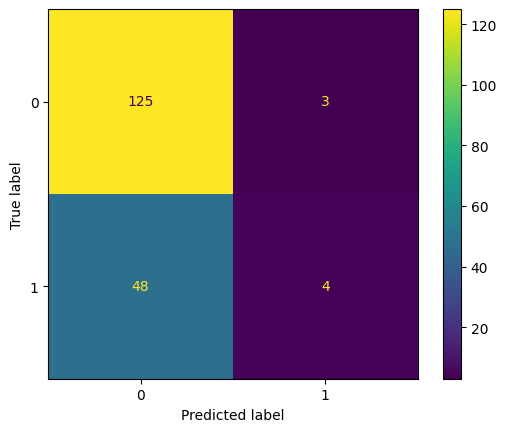

In [22]:
random_forest_confusion_matrix = confusion_matrix(y1_test, random_forest_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=random_forest_confusion_matrix)
disp.plot();

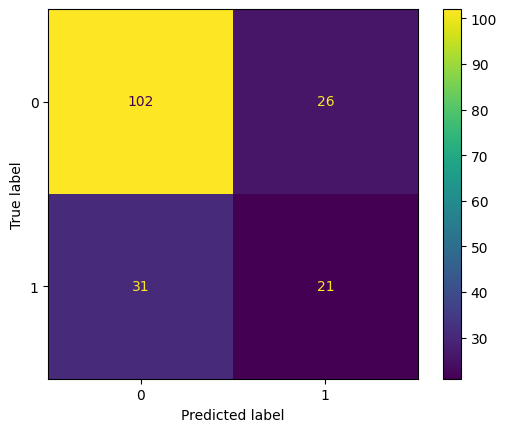

In [23]:
sk_random_forest_confusion_matrix = confusion_matrix(y1_test, sk_random_forest_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=sk_random_forest_confusion_matrix)
disp.plot();

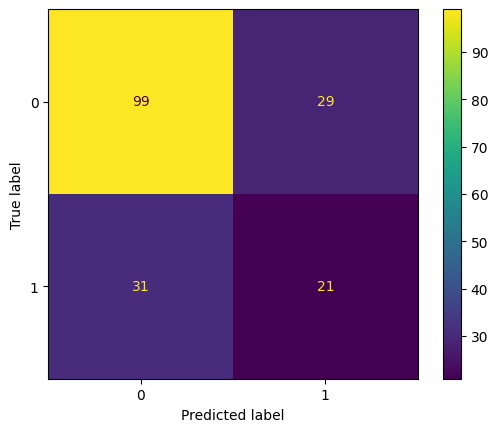

In [24]:
sk_extra_trees_confusion_matrix = confusion_matrix(y1_test, sk_extra_trees_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=sk_extra_trees_confusion_matrix)
disp.plot();

Далее сравним результаты работы моделей с помощью **ROC-метрики**.

Построим график с ROC-кривыми, каждой модели.

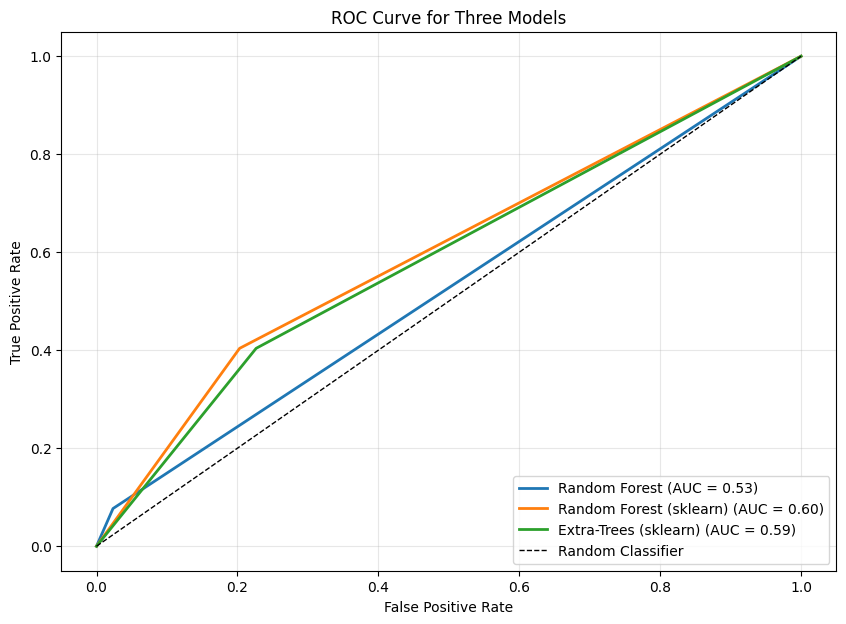

In [25]:
# Вычисляем ROC и AUC для каждой модели
fpr1, tpr1, _ = roc_curve(y1_test, random_forest_prediction)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y1_test, sk_random_forest_prediction)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y1_test, sk_extra_trees_prediction)
roc_auc3 = auc(fpr3, tpr3)

# Построение ROC-графика
plt.figure(figsize=(10, 7))

plt.plot(fpr1, tpr1, label=f'Random Forest (AUC = {roc_auc1:.2f})', linewidth=2)
plt.plot(fpr2, tpr2, label=f'Random Forest (sklearn) (AUC = {roc_auc2:.2f})', linewidth=2)
plt.plot(fpr3, tpr3, label=f'Extra-Trees (sklearn) (AUC = {roc_auc3:.2f})', linewidth=2)

# Добавим линию случайного классификатора
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Three Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()